In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation,binary_erosion

In [5]:
floor_width = 9.77 #m
floor_height =  5.30#m

In [6]:
floor_color = (255,0,0) # np.asarray([255,133,0])
start_pos_color = (0,255,0)
floor_delta = 7
start_pos_delta = 0

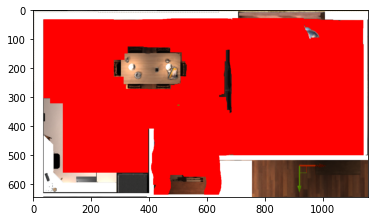

In [7]:
exported_map = np.asarray(Image.open("/home/rene/catkin_ws/src/active_learning_for_segmentation/embodied_active_learning/scripts/map_generation/map/BigFlatLivingRoomWithDresser.png"))[:,:,0:3]
plt.imshow(exported_map)

In [8]:
masks_floor = [np.logical_and(exported_map[:,:,i] <= floor_color[i] + floor_delta, exported_map[:,:,i] >= floor_color[i] - floor_delta) for i in range(3)]
masks_start = [np.logical_and(exported_map[:,:,i] <= start_pos_color[i] + start_pos_delta, exported_map[:,:,i] >= start_pos_color[i] - start_pos_delta) for i in range(3)]
map_occupied = np.logical_not(np.logical_or(np.logical_and(*masks_floor), np.logical_and(*masks_start)))

In [9]:
player_start = np.where(np.logical_and(*masks_start))
player_start_coord = player_start[0][0], player_start[1][0]

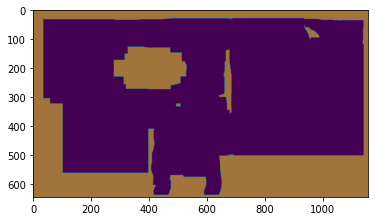

In [10]:
plt.imshow(map_occupied)
plt.imshow(binary_dilation(np.logical_and(*masks_start), structure = np.ones((10,10))), alpha = 0.5)

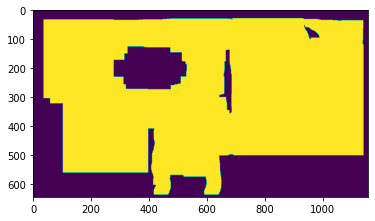

In [11]:
map_free = np.logical_not(map_occupied)
plt.imshow(map_free)

In [13]:
width_px = 0
for row_idx in range(map_free.shape[0]):
    row = map_free[row_idx, :]
    match = np.where(row == True)[0]
    if len(match) == 0:
        continue
    width = match[-1] - match[0]
    if width > width_px:
        width_px = width

height_px = 0
for row_idx in range(map_free.shape[1]):
    row = map_free[:, row_idx]
    match = np.where(row == True)[0]
    if len(match) == 0:
        continue
    width = match[-1] - match[0]
    if width > height_px:
        height_px = width
    

## Use Binary Dilation to make sure drone will never move too close to object boundaries

In [14]:
width_pixel = width_px #map_free.shape[1]
height_pixel = height_px # map_free.shape[0]

length_per_pixel = 1/2 * (floor_width/width_pixel + floor_height/height_pixel) 
map_width = map_free.shape[1]*length_per_pixel
map_height =  map_free.shape[0]*length_per_pixel
print("map shape [m]: ", map_height, map_width)

map shape [m]:  5.6673231976861205 10.16603556546177


In [15]:
dilated = binary_dilation(map_occupied, structure = np.ones((25,25)))

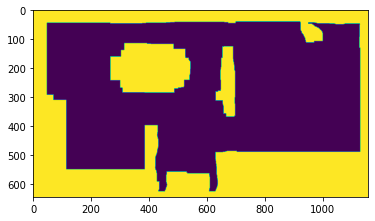

In [16]:
plt.imshow(dilated)

Number of objects is 1


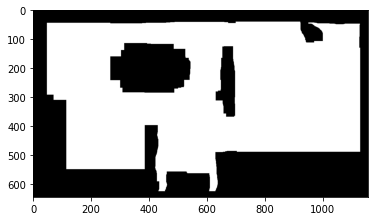

In [17]:
labeled, nr_objects = ndimage.label(np.logical_not(dilated) )
print("Number of objects is {}".format(nr_objects))
if nr_objects != 1:
    max_idx = np.argmax(np.asarray([np.sum(labeled == i) for i in range(1,nr_objects)])) + 1
    final_free_map =  labeled == max_idx
else:
    final_free_map = dilated

final_free_map_pil = Image.fromarray(np.logical_not(final_free_map))
plt.imshow(final_free_map_pil)

In [18]:
# Save a dictionary into a pickle file.
import pickle


In [20]:
player_start_coord

(327, 499)

In [19]:
# Save a dictionary into a pickle file.
import pickle
 
pickle.dump({'map': np.logical_not(final_free_map),
             'dimensions': {
                 'height': map_height,
                 'width':map_width,
                 'lengthPerPixel': length_per_pixel
             },
             'start': {
                 'top': player_start_coord[0],
                 'left': player_start_coord[1]
             }
            }, open( "BigFlatLivingRoomWithDresser.pickle", "wb" ), protocol = 2 )
